# Sparse Probabilistic Count Matrix Factorization

In [1]:
from pCMF.misc import utils
from pCMF.models.pcmf import cavi, svi, gibbs, cavi_spcmf

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

# plt.style.use('ggplot')

In [46]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.3
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_sparse_data(N, P, K, C=C, zero_prob=z_p, noisy_prop=0.5,
                                                 eps_U=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

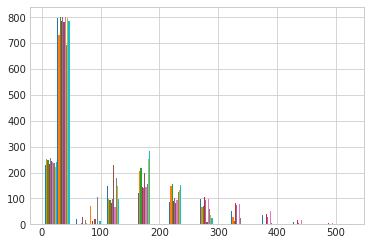

In [48]:
plt.hist(Y_train)
plt.show()

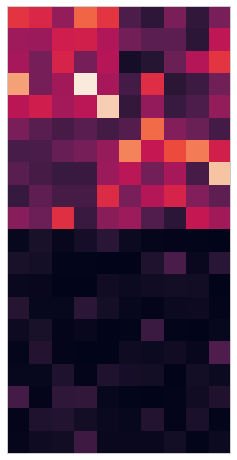

In [47]:
plt.matshow(V)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
T = 60.
S = 1.

In [16]:
# Experiment parameters
N = 1000 # number of observations
P = 20 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.3
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_data(N, P, K, C=C, zero_prob=z_p,
                                                 eps=eps, return_all=True)

Y_train, Y_test, U_train, U_test, c_train, c_test = train_test_split(Y, U.T, clusters, test_size=0.2, random_state=42)

In [34]:
# Run PCA
pca_U = PCA(n_components=2).fit_transform(np.log(Y_train + 1.))

# Run CAVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
print('PCMF:')
inf = cavi.CoordinateAscentVI(Y_train, alpha, beta, pi_D)
pcmf_ll = inf.run_cavi(n_iterations=4000, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
pcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
pcmf_U = PCA(n_components=2).fit_transform(pcmf_U)

PCMF:
Iteration 50/4000. Log-likelihood: 34.240. Elapsed: 60 seconds


In [49]:
# Run CAVI and get estimates (Sparse pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi_D = np.ones((P,)) * 0.5
pi_S = np.ones((P,)) * 0.5
print('PCMF sparse:')
inf = cavi_spcmf.CoordinateAscentVI(Y_train, alpha, beta, pi_D, pi_S)
spcmf_ll = inf.run_cavi(n_iterations=4000, empirical_bayes=False, return_ll=True, sampling_rate=S, max_time=T)
spcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
spcmf_U = PCA(n_components=2).fit_transform(spcmf_U)

PCMF sparse:


In [50]:
inf.p_S

array([[9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01, 9.999999e-01, 9.999999e-01,
        9.999999e-01, 9.999999e-01],
       [1.

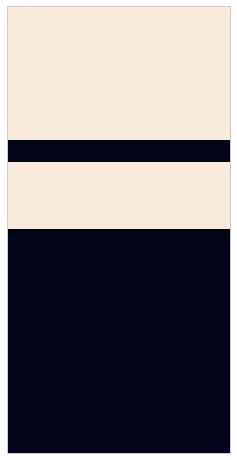

In [54]:
plt.matshow(inf.p_S)
plt.xticks([])
plt.yticks([])
plt.show()

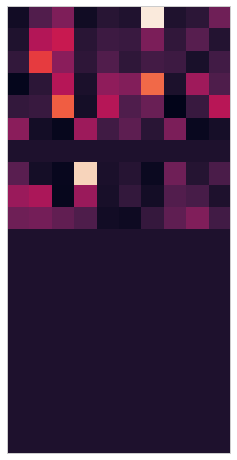

In [52]:
est_V = inf.estimate_V(inf.b)
plt.matshow(est_V)
plt.xticks([])
plt.yticks([])
plt.show()

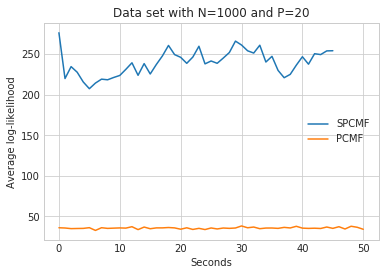

In [53]:
plt.plot(spcmf_ll[1], label='SPCMF')
plt.plot(pcmf_ll[0], label='PCMF')
plt.ylabel('Average log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

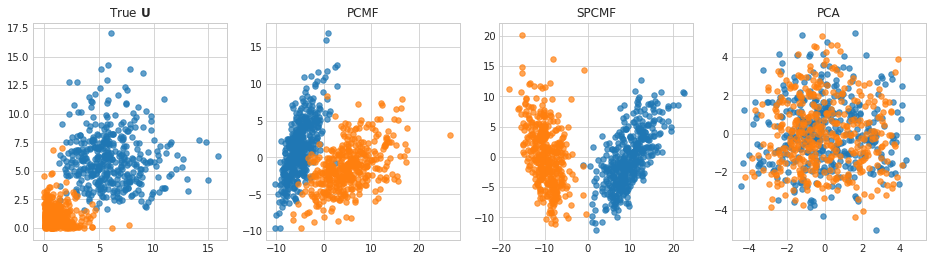

In [55]:
U_list = [U_train, pcmf_U, spcmf_U, pca_U]
title_list = ['True $\mathbf{U}$', 'PCMF', 'SPCMF', 'PCA']

n_results = len(U_list)

assert len(U_list) == len(title_list)

fig = plt.figure(figsize=(16, 4))

s = 30
alpha = 0.7
labels=None
for i in range(len(U_list)):
    ax = plt.subplot(1, n_results, i+1)
    handlers = []
    for c in range(C):
        h = ax.scatter(U_list[i][c_train==c, 0], U_list[i][c_train==c, 1], s=s, alpha=alpha)
        handlers.append(h)
    if labels is not None:
        ax.legend(handlers, labels, scatterpoints=1)
    plt.title(title_list[i])
plt.show()

In [56]:
true_silh = silhouette_score(U_train, c_train)
pcmf_silh = silhouette_score(pcmf_U, c_train)
spcmf_silh = silhouette_score(spcmf_U, c_train)
# hpcmf_silh = silhouette_score(hpcmf_U, c_train)
# shpcmf_silh = silhouette_score(shpcmf_U, c_train)
pca_silh = silhouette_score(pca_U, c_train)

# scores = {'SPCMF': spcmf_silh, 'PCMF': pcmf_silh, 'PCA': pca_silh, 'HPCMF': hpcmf_silh, 'SHPCMF': shpcmf_silh}
scores = {'SPCMF': spcmf_silh, 'PCMF': pcmf_silh, 'PCA': pca_silh}

sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('\033[1m- {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
for score_tp in sorted_scores[1:]:
    print('- {0}: {1:.3}'.format(score_tp[0], score_tp[1]))
    
print('\nSilhouette of true U:')
print('%0.3f' % true_silh)

Silhouette scores (higher is better):
- SPCMF: 0.639
- PCMF: 0.457
- PCA: -0.000181

Silhouette of true U:
0.540
